### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the enriched dataset

In [2]:
df = pd.read_csv("../data/processed/ethiopia_fi_unified_data_enriched.csv")
df.head()

,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN


### Separate Events, Observations, and Impact Links

In [3]:
events = df[df["record_type"] == "event"].copy()
observations = df[df["record_type"] == "observation"].copy()
impact_links = df[df["record_type"] == "impact_link"].copy()

print("Events:", events.shape)
print("Observations:", observations.shape)
print("Impact Links:", impact_links.shape)

Events: (12, 34)
Observations: (33, 34)
Impact Links: (3, 34)


### Inspect impact_links

In [4]:
impact_links.head()

# Ensure columns needed for Task 3 exist
impact_links.columns


Index(['record_id', 'record_type', 'category', 'pillar', 'indicator',
       'indicator_code', 'indicator_direction', 'value_numeric', 'value_text',
       'value_type', 'unit', 'observation_date', 'period_start', 'period_end',
       'fiscal_year', 'gender', 'location', 'region', 'source_name',
       'source_type', 'source_url', 'confidence', 'related_indicator',
       'relationship_type', 'impact_direction', 'impact_magnitude',
       'impact_estimate', 'lag_months', 'evidence_basis', 'comparable_country',
       'collected_by', 'collection_date', 'original_text', 'notes'],
      dtype='object')

### Map qualitative impact magnitudes to numeric

In [5]:
IMPACT_SCALE = {
    "low": 0.5,
    "medium": 1.5,
    "high": 3.0
}

impact_links["impact_numeric"] = impact_links["impact_magnitude"].map(IMPACT_SCALE)

# Check mapping
impact_links[["record_id", "related_indicator", "impact_magnitude", "impact_numeric"]].head(10)


,record_id,related_indicator,impact_magnitude,impact_numeric
46,LNK_NEW_001,DIGITAL_PAYMENTS,high,3.0
49,LNK_NEW_002,DIGITAL_PAYMENTS,medium,1.5
50,LNK_NEW_003,ACCOUNT_OWNERSHIP,medium,1.5


### Create Impact Summary Table

In [6]:
impact_summary = impact_links[[
    "record_id",          # Event ID
    "related_indicator",  # Affected Indicator
    "impact_direction",
    "impact_magnitude",
    "impact_numeric",
    "lag_months",
    "evidence_basis"
]]

# Save summary
impact_summary.to_csv(
    "../data/processed/event_indicator_summary.csv",
    index=False
)

impact_summary.head()

,record_id,related_indicator,impact_direction,impact_magnitude,impact_numeric,lag_months,evidence_basis
46,LNK_NEW_001,DIGITAL_PAYMENTS,positive,high,3.0,6.0,Observed growth after launch
49,LNK_NEW_002,DIGITAL_PAYMENTS,positive,medium,1.5,3.0,Observed uptake after interoperability
50,LNK_NEW_003,ACCOUNT_OWNERSHIP,positive,medium,1.5,6.0,Observed improvement in account ownership


### Build Event–Indicator Association Matrix

In [7]:
association_matrix = impact_links.pivot_table(
    index="record_id",
    columns="related_indicator",
    values="impact_numeric",
    aggfunc="sum"
).fillna(0)

# Save matrix
association_matrix.to_csv("../data/processed/event_indicator_matrix.csv")

association_matrix.head()


related_indicator,ACCOUNT_OWNERSHIP,DIGITAL_PAYMENTS
record_id,,
LNK_NEW_001,0.0,3.0
LNK_NEW_002,0.0,1.5
LNK_NEW_003,1.5,0.0


### Visualize Event–Indicator Association Matrix as Heatmap

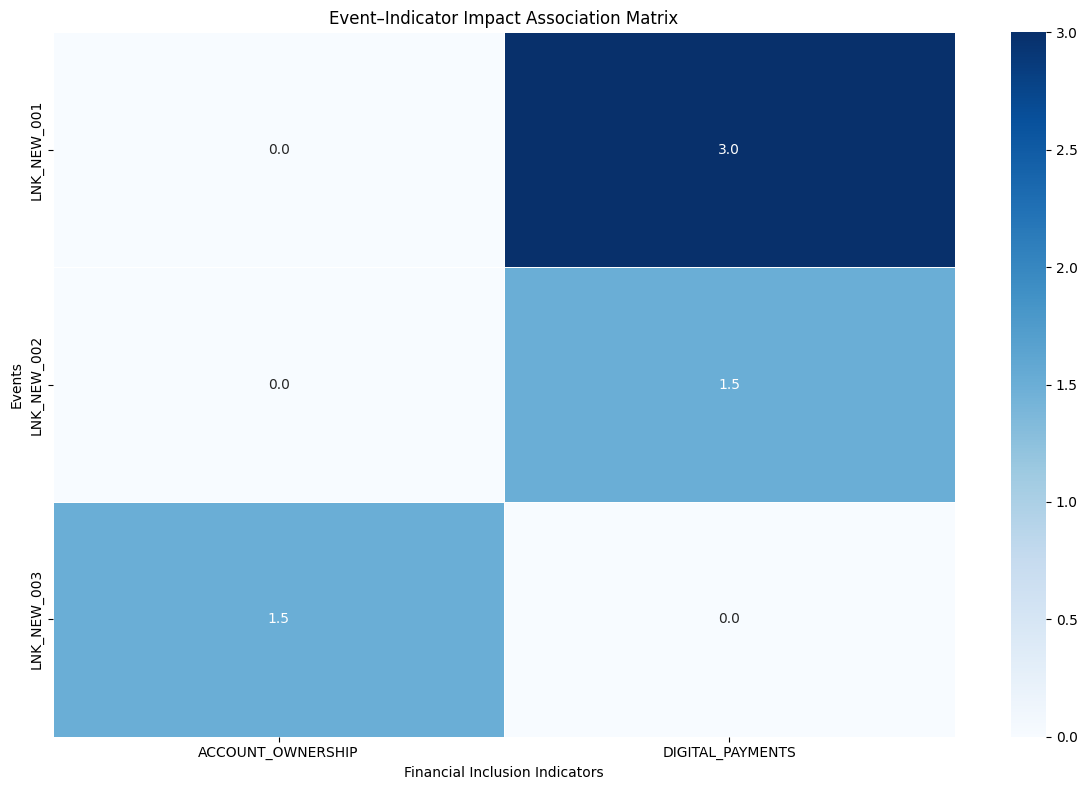

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    association_matrix,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=0.5
)
plt.title("Event–Indicator Impact Association Matrix")
plt.xlabel("Financial Inclusion Indicators")
plt.ylabel("Events")
plt.tight_layout()
plt.savefig("../reports/figures/event_indicator_heatmap.png", dpi=300)
plt.show()

### Validate Model Against Historical Data (Telebirr)

In [9]:
# Observed account growth
observed_2021 = 4.7
observed_2024 = 9.45
observed_growth = (observed_2024 - observed_2021) / observed_2021 * 100  # in percentage

# Telebirr event impacts
telebirr_links = impact_links[impact_links["notes"].str.contains("Telebirr", na=False)]
model_growth = telebirr_links["impact_numeric"].sum()  # sum of mapped numeric impacts

# Create validation table
validation = pd.DataFrame({
    "indicator": ["Mobile Money Account Ownership"],
    "observed_growth_pct": [observed_growth],
    "model_estimated_growth": [model_growth],
    "difference": [observed_growth - model_growth]
})

# Save validation
validation.to_csv("../data/processed/impact_model_validation.csv", index=False)
validation


,indicator,observed_growth_pct,model_estimated_growth,difference
0,Mobile Money Account Ownership,101.06383,3.0,98.06383
